In [76]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D


In [77]:
from util.random import fourierGP_2D_lerp, smooth_random_loop_fourier_coef
import dolfin as dl
import fenics as fn
import mshr as ms
    
def square(N):
    x = np.linspace(-1, 1, N+1)[1:]
    c = np.ones_like(x)
    
    x_sq = np.hstack([x, c, x[::-1], -c]) * 0.3
    y_sq = np.hstack([-c, x, c, x[::-1]]) * 0.3
    
    x_n = np.hstack([0*c, c, 0*c, -c])
    y_n = np.hstack([-c, 0*c, c, 0*c])
    return x_sq, y_sq, x_n, y_n

def loop(N, size):
    K = 11
    cs = smooth_random_loop_fourier_coef(K)
    ks = np.arange(-K, K, 1)
    f = lambda t: (np.exp(1j * ks[None, :] * t[:, None]) @ cs).real * size
    df = lambda t: (1j * ks[None, :] * np.exp(1j * ks[None, :] * t[:, None]) @ cs).real * size
                
    t = np.linspace(0, 2*np.pi, N+1)[:-1]
    xy = f(t)
    dxy = df(t)
    dxy = dxy / np.linalg.norm(dxy, axis=1)[:,None]
    return xy[:,0], xy[:,1], -dxy[:,1], dxy[:,0]

def to_poly(x, y, n_subsample, **kwargs):
    try:
        return ms.Polygon([dl.Point(x[i], y[i]) for i in range(0, len(x), n_subsample)], **kwargs)
    except:
        return ms.Polygon([dl.Point(x[i], y[i]) for i in range(0, len(x), n_subsample)[::-1]], **kwargs)

(0.016713802818175583, 0.2167138028181756)

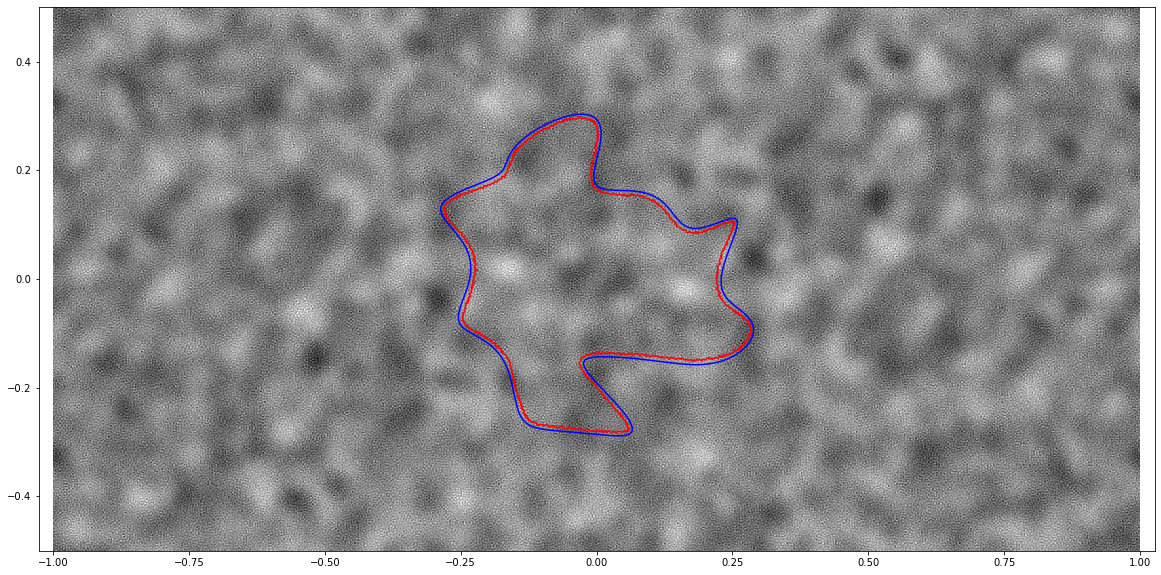

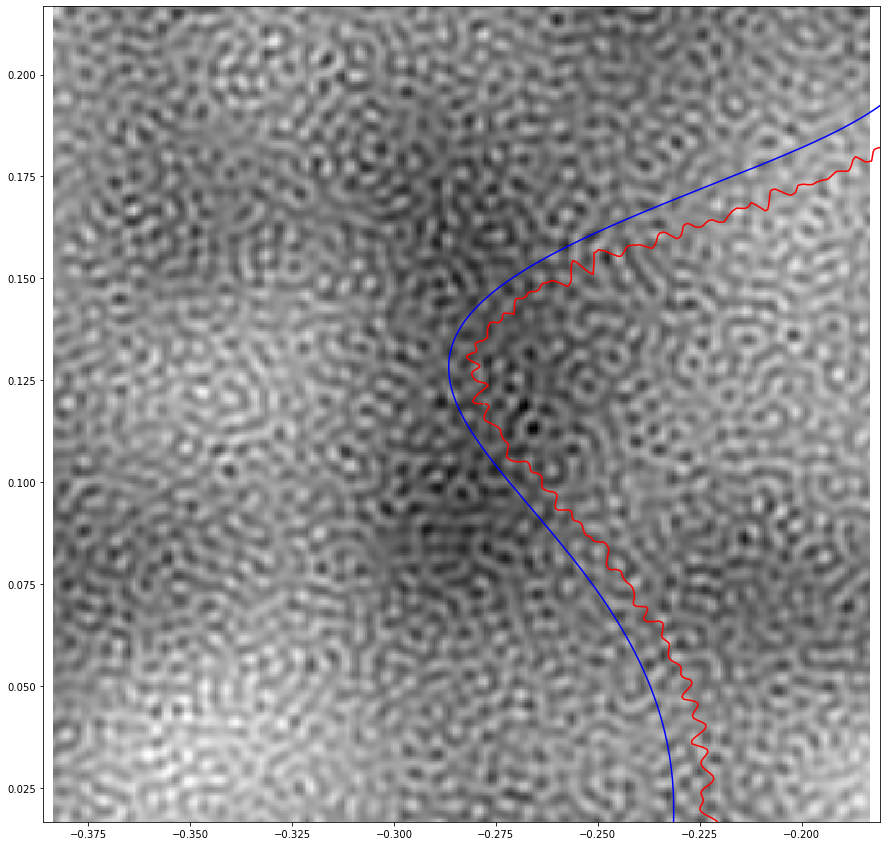

In [78]:
kmax = 801#2000
L = 0.08#0.04
Leff = 0.08
eps = 0.005
a = 1/2
dom = [[-1,1], [-a, a]]

lerp, x, y = fourierGP_2D_lerp(kmax, kmax, L, eps, dom)
X,Y = np.meshgrid(x, y)

#p = 1
#corner = lambda x,y : np.exp(-(1e-3**p)/(np.abs(np.abs(x)-.3)**2+np.abs(np.abs(y)-.3)**2)**p)
#x_s, y_s, x_n, y_n = square(500)
x_s, y_s, x_n, y_n = loop(4000, 0.3)
d_s = lerp(x_s, y_s) * eps * 3 #* 3 * corner(x_s, y_s)

# FIeld
plt.figure(figsize=(20,10))
plt.pcolormesh(X, Y, lerp.Z, cmap='gray')
plt.plot(x_s - d_s * x_n, y_s - d_s * y_n, 'r')
plt.plot(x_s, y_s, 'b')
plt.axis('equal')
plt.xlim(*dom[0])
plt.ylim(*dom[1])


# Zoom
plt.figure(figsize=(15, 15))
w = 20
x0 = x_s[0]
y0 = y_s[0]
zoomdom = [[x0-eps*w, x0+eps*w], [y0-eps*w, y0+eps*w]]
xz = np.linspace(*zoomdom[0], 500)
yz = np.linspace(*zoomdom[1], 500)
Xz, Yz = np.meshgrid(xz, yz)
plt.pcolormesh(Xz, Yz, lerp(Xz.flatten(), Yz.flatten()).reshape(Xz.shape), cmap='gray')
plt.plot(x_s - d_s * x_n, y_s - d_s * y_n, 'r')
plt.plot(x_s, y_s, 'b')
plt.axis('equal')
plt.xlim(*zoomdom[0])
plt.ylim(*zoomdom[1])

<class 'ufl.geometry.FacetNormal'>


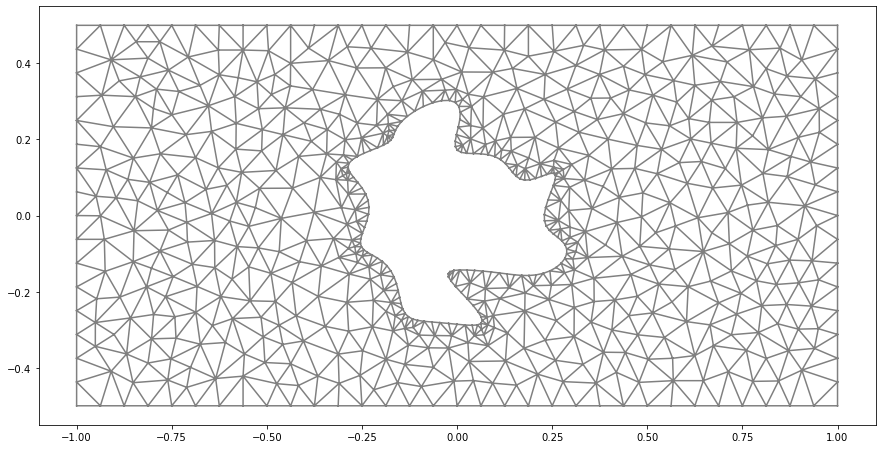

In [84]:
plt.figure(figsize=(15, 15))

class Blob(dl.SubDomain):
    def inside(self, x, on_boundary):
        return bool(max(abs(x[0]), abs(x[1])) < 0.4 + dl.DOLFIN_EPS)# and on_boundary)


def distance_to_line_segment(x, a, b):
    """Closest distance between point x and line segment ab"""
    ab = b - a
    ax = x - a
    bx = x - b
    if np.dot(ax, ab) <= 0:
        return np.linalg.norm(ax)
    elif np.dot(bx, -ab) <= 0:
        return np.linalg.norm(bx)
    else:
        return np.linalg.norm(np.cross(ab, ax)) / np.linalg.norm(ab)


def closest_boundary_facet(x, mesh):
    dist = np.inf
    for facet in dl.facets(mesh):
        print(facet)
        verts = [vertex.point().array()[0:2] for vertex in dl.vertices(facet)]
        dist = min(dist, distance_to_line_segment(x, verts[0], verts[1]))
    return dist

pol = to_poly(x_s, y_s, 30)
domain = ms.Rectangle(dl.Point(dom[0][0], dom[1][0]), dl.Point(dom[0][1], dom[1][1])) - pol
mesh  = ms.generate_mesh(domain, resolution=20)

n = dl.FacetNormal(mesh)
print(type(n))
dl.plot(mesh)
#plt.xlim(*zoomdom[0])
#plt.ylim(*zoomdom[1])

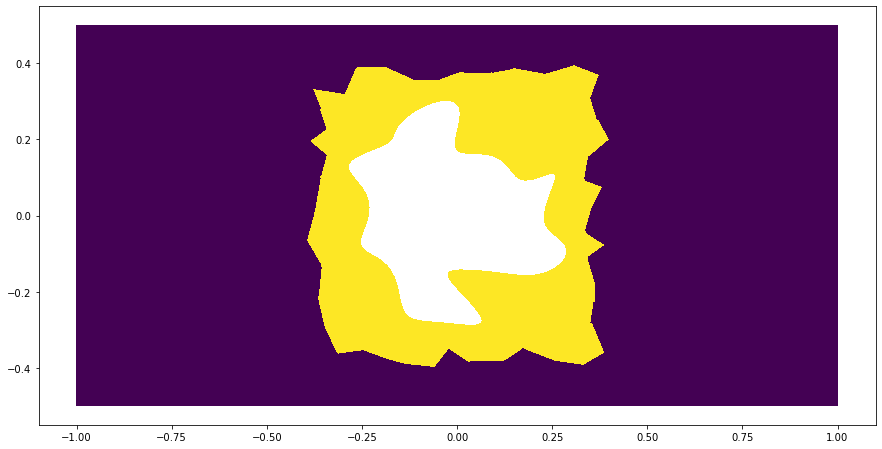

In [85]:
on_blob = dl.MeshFunction('size_t', mesh, 2)
on_blob.set_all(0)
Blob().mark(on_blob, 1)
plt.figure(figsize=(15, 15))
dl.plot(on_blob)

In [1]:
exterior = dl.BoundaryMesh(mesh, 'exterior')
bmeshes = []
bbtrees = []
for boundary in [Blob()]:
    bmeshes.append(dl.SubMesh(exterior, boundary))
    bbtrees.append(dl.BoundingBoxTree())
    bbtrees[-1].build(bmeshes[-1])


p = dl.Point([0.5, 0.5])
idx, distance = bbtrees[0].compute_closest_entity(p)
print(f"HELLO {idx}, {distance}", end='\n')

v = dl.Vertex(mesh, idx).point()

dl.plot(bmeshes[0])
plt.scatter(p[0], p[1])
plt.scatter(v[0], v[1], s=200, c='r')
print(v[0], v[1])
plt.axis()
#distances = dl.MeshFunction("double", mesh, dim=2)
#for v_idx in range(mesh.num_vertices()):
    #v = dl.Vertex(mesh, v_idx)
    #_, distance = bbtree.compute_closest_entity(v.point())
    #distances[v_idx] = distance


NameError: name 'dl' is not defined

In [6]:


def closest_point_in_mesh(p, mesh):
    """Finds the nearest point in a mesh to a given point
    p is the point or points (numpy array)
    mesh is the fenics/dolfin mesh

    p.shape = (N,) OR (num_pts, N) for vectorization over many points
    N = dimension of ambient space

    Example usage:
        import numpy as np
        import dolfin as dl
        import matplotlib.pyplot as plt
        mesh = dl.UnitSquareMesh(13,9)
        num_pts = 20
        p = np.random.randn(num_pts, 2) + np.array([0.5, 0.5])
        closest_p = closest_point_in_mesh(p, mesh)
        plt.figure()
        dl.plot(mesh)
        for ii in range(num_pts):
            plt.plot([p[ii,0], closest_p[ii,0]], [p[ii,1], closest_p[ii,1]], 'b')
            plt.plot(p[ii,0], p[ii,1], '*k')
            plt.plot(closest_p[ii,0], closest_p[ii,1], '.r')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p[None,:]
    else:
        PP = p
    num_pts, N = PP.shape
    tdim = mesh.topology().dim()
    k = tdim + 1

    VV = np.zeros((num_pts, k, N))
    bbt = mesh.bounding_box_tree()
    for ii in range(num_pts):
        pi = PP[ii,:]
        closest_entity, closest_distance = bbt.compute_closest_entity(dl.Point(pi))
        closest_cell = mesh.cells()[closest_entity]
        vertices_of_closest_cell = mesh.coordinates()[closest_cell, :]
        VV[ii, :, :] = vertices_of_closest_cell

    closest_PP = closest_point_on_simplex(PP, VV)

    if len(p.shape) == 1:
        closest_PP = closest_PP.reshape(-1)
    return closest_PP

ModuleNotFoundError: No module named 'dolfinx'

In [32]:
#print(n.is_cellwise_constant())
help(n)

True
Help on FacetNormal in module ufl.geometry object:

class FacetNormal(GeometricFacetQuantity)
 |  FacetNormal(domain)
 |  
 |  UFL geometry representation: The outwards pointing normal vector of the current facet.
 |  
 |  Method resolution order:
 |      FacetNormal
 |      GeometricFacetQuantity
 |      GeometricQuantity
 |      ufl.core.terminal.Terminal
 |      ufl.core.expr.Expr
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __hash__ = compute_expr_hash(expr)
 |      Compute hashes of *expr* and all its nodes efficiently, without using Python recursion.
 |  
 |  is_cellwise_constant(self)
 |      Return whether this expression is spatially constant over each cell.
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  ufl_shape
 |      Return the number of coordinates defined (i.e. the geometric dimension
 |      of the domain).
 |  
 |  ---------------------------------------------------

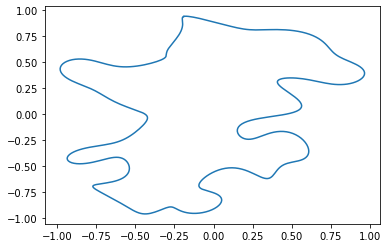

In [27]:
from fenics import *
from dolfin import *
from util.random import smooth_random_loop_fourier_coef

K = 21
cs = smooth_random_loop_fourier_coef(K)
ks = np.arange(-K, K, 1)
f = lambda t: (np.exp(1j * ks[None, :] * t[:, None]) @ cs).real
df = lambda t: (1j * ks[None, :] * np.exp(1j * ks[None, :] * t[:, None]) @ cs).real
            
t = np.linspace(0, 2*np.pi, 500)
xy = f(t)

plt.plot(xy[:,0], xy[:,1])